## Car dataset clustering

In [1]:
#  kaggle : https://www.kaggle.com/datasets/uciml/autompg-dataset?datasetId=1489
#  original link : https://archive.ics.uci.edu/dataset/9/auto+mpg

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

from sklearn.preprocessing import StandardScaler

import umap
import umap.plot as uplot

from ch_9_funcs import plot_cluster_dendrogram, plot_silouethes_agglomer, cophenetic_corr

sns.set_theme()

/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

### Load and preprocess the data

The car MPG (Miles Per Gallon) dataset, often known as the Auto MPG dataset, is a popular collection of data that was sourced from the 1970s and 1980s. It provides a detailed insight into various attributes of cars that were in the market during that period. 

Dataset contains following columns:

1. `mpg`: Stands for Miles Per Gallon. This measures the distance in miles that a car can travel per gallon of fuel.

2. `cylinders`: Indicates the number of cylinders in the car's engine. This can be related to the power output of the engine.

3. `displacement`: A measure of the total volume of all the cylinders in an engine, typically measured in cubic inches or cubic centimeters.

4. `horsepower`: The power output of the car's engine, typically measured in horsepower.

5. `weight`: The total weight of the car, typically measured in pounds.

6. `acceleration`: A measure of how quickly the car can increase its speed, typically represented in seconds to go from 0 to 60 miles per hour.

7. `model year`: The year when the car model was released, typically represented as a two-digit number from 70 to 82 (for 1970 to 1982).

8. `origin`: A categorical variable representing the region where the car was manufactured. This is usually represented as a number: 1 for America, 2 for Europe, and 3 for Asia.

9. `car name`: The full name of the car model, typically in the format of "Manufacturer Model" (e.g., "ford torino").

Citation :  Quinlan,R.. (1993). Auto MPG. UCI Machine Learning Repository. https://doi.org/10.24432/C5859H.



In [ ]:
# Load car mpg dataset
car_df_path = 'data/cars/auto-mpg.csv'
car_df = pd.read_csv(car_df_path)
car_df.shape

(398, 9)

In [3]:
# Preview
car_df.head()

mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

In [4]:
# Check for missing values
car_df.isna().sum(axis=0)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [5]:
# Preview column datatypes
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
car_df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [7]:
# Remove missing values
car_df = car_df[car_df['horsepower'] != '?'].reset_index(drop=True)
car_df.shape

(392, 9)

In [8]:
# Get number of unique car names
car_df['car name'].nunique()

301

In [9]:
# Give unique name to each car by adding prefix (nth_occurence_car-name)
diversifier = car_df.groupby('car name').cumcount().to_numpy()
diversifier = ['' if val==0 else '_' + str(val) for val in diversifier]
diversifier = pd.Series(diversifier)
car_df['car name'] = car_df['car name'] + diversifier + '_' + car_df['model year'].astype(str)

# Set car name as index
car_df = car_df.set_index('car name', drop=True)

In [10]:
# Cast other columns to float
car_df = car_df.astype(np.float32)

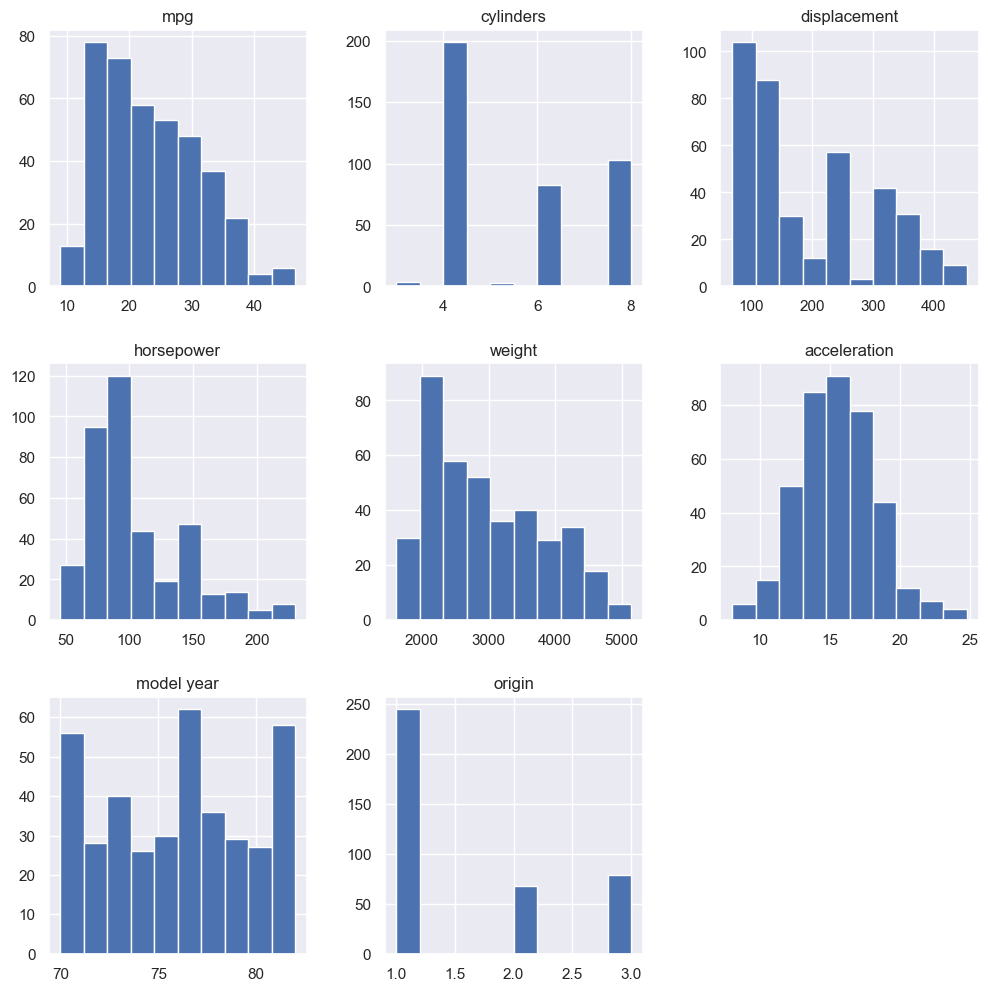

In [11]:
# Plot variable value distribution
_ = car_df.hist(figsize=(12,12))

In [15]:
# Remove origin column and save it as separate variable
origin = car_df['origin']

origin_mapping = {1: 'USA', 2: 'Europe', 3: 'Asia'}
origin = origin.map(origin_mapping)
origin[:5]

car name
chevrolet chevelle malibu_70    USA
buick skylark 320_70            USA
plymouth satellite_70           USA
amc rebel sst_70                USA
ford torino_70                  USA
Name: origin, dtype: object

In [27]:
# Make a copy of the dataframe for latter use
car_df_copy = car_df.copy()
car_df_copy['origin'] = origin

car_df = car_df.drop(columns=['origin'])


In [16]:
# Scale the data
scaler = StandardScaler()
car_df[:] = scaler.fit_transform(car_df)

## Agglomerative clustering

In [17]:
linkage_matrix = linkage(car_df.to_numpy(), method='ward')

In [18]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx = car_df.to_numpy()
)

Cophenetic correlation : 0.6824190949286509


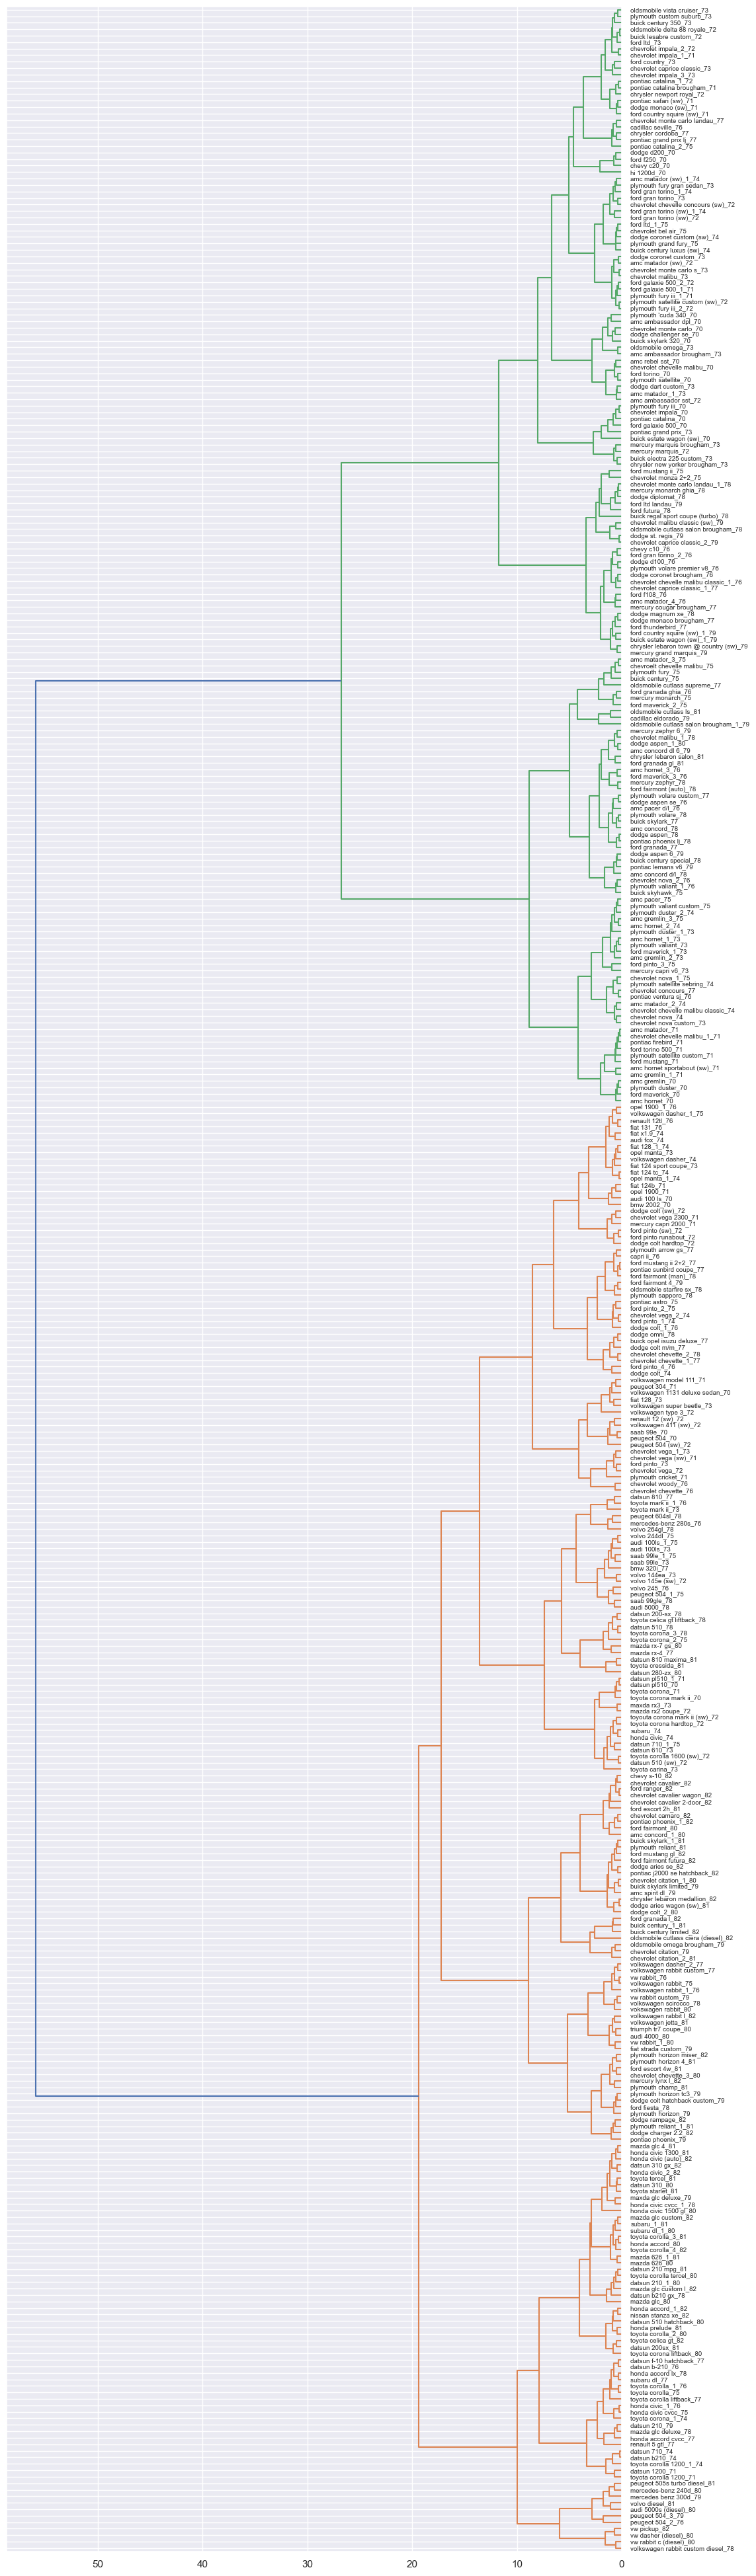

In [19]:
# Plot dendrogram and label it by car type
plt.rcParams['figure.figsize'] = [12, 50]
_ = dendrogram(
    linkage_matrix, 
    labels=car_df.index,
    orientation='left', 
    leaf_font_size=7
)

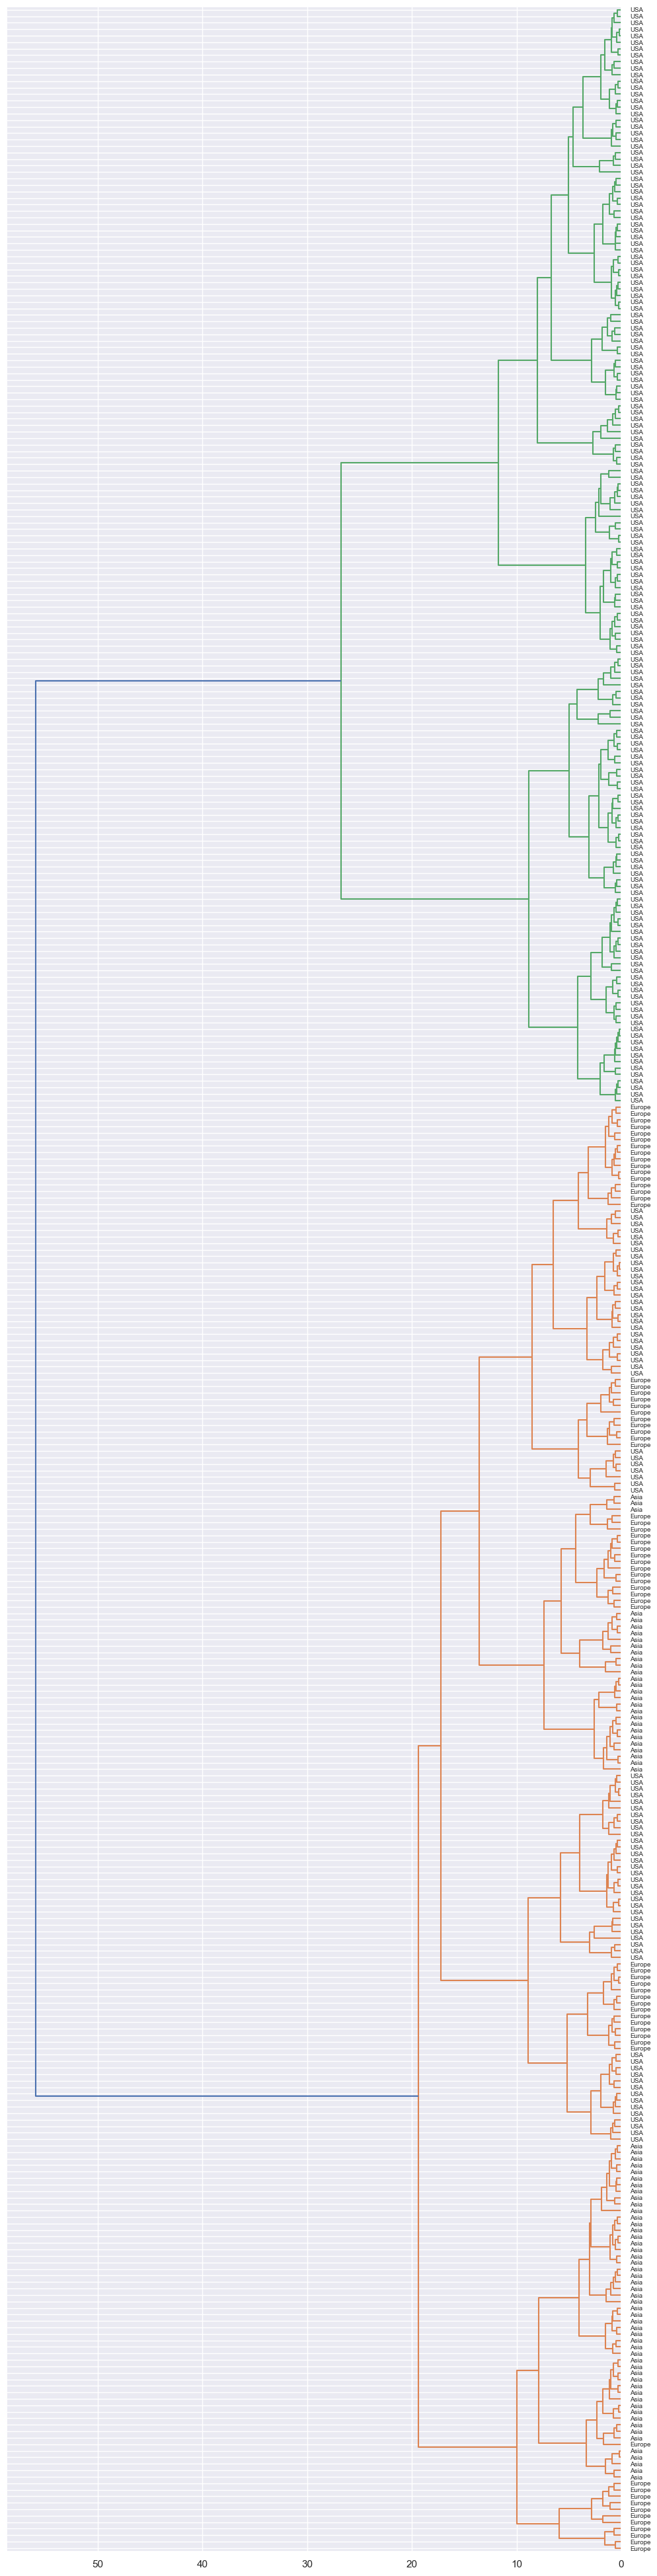

In [20]:
# Plot dendrogram and add country of origin
plt.rcParams['figure.figsize'] = [12, 50]
_ = dendrogram(
    linkage_matrix, 
    labels=origin.values,
    orientation='left',
    leaf_font_size=7
)

### Clustering using the height method

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/ml_env/lib/python3.11/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

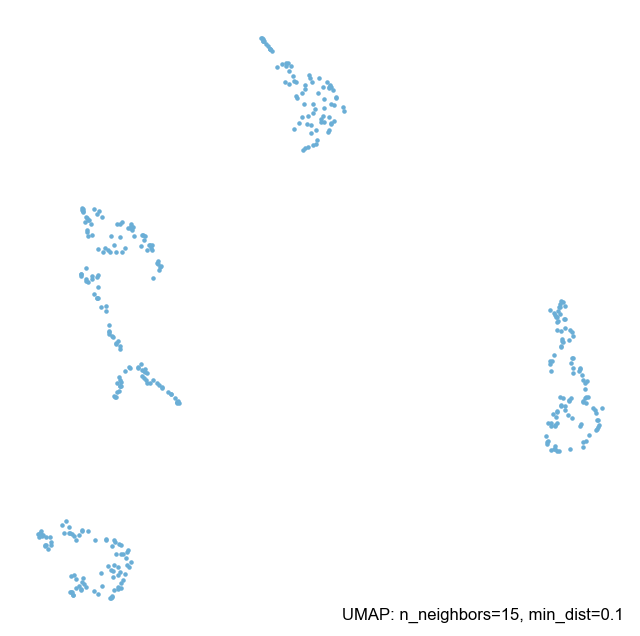

In [21]:
# Perfrom UMAP dimensionality reduction
umap_obj = umap.UMAP(n_neighbors=15)
embedding_mtx = umap_obj.fit_transform(car_df)

uplot.points(umap_obj)

<Axes: >

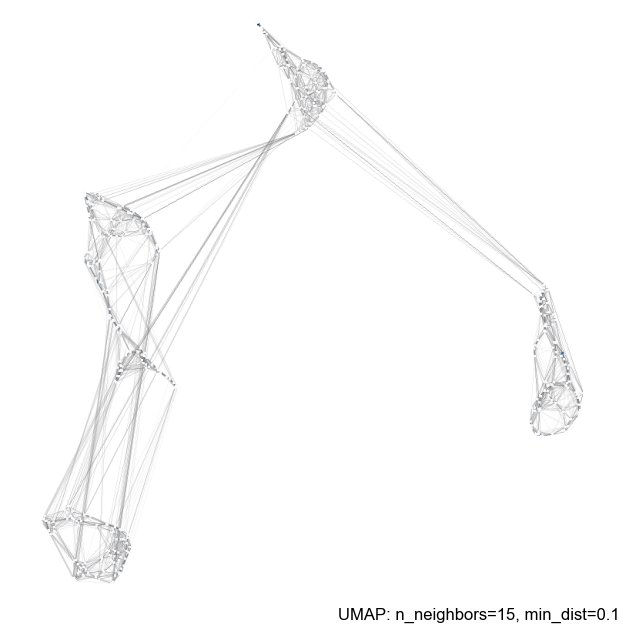

In [22]:
umap.plot.connectivity(umap_obj, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

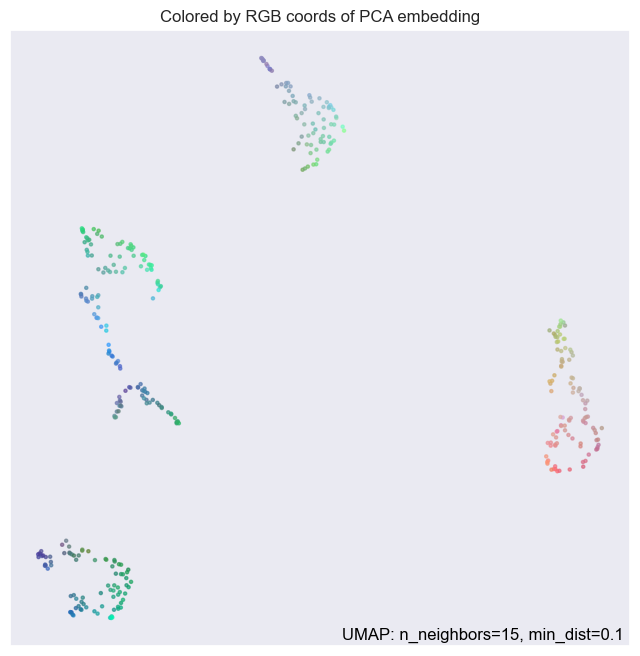

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
umap.plot.diagnostic(umap_obj, diagnostic_type='pca',ax=ax)

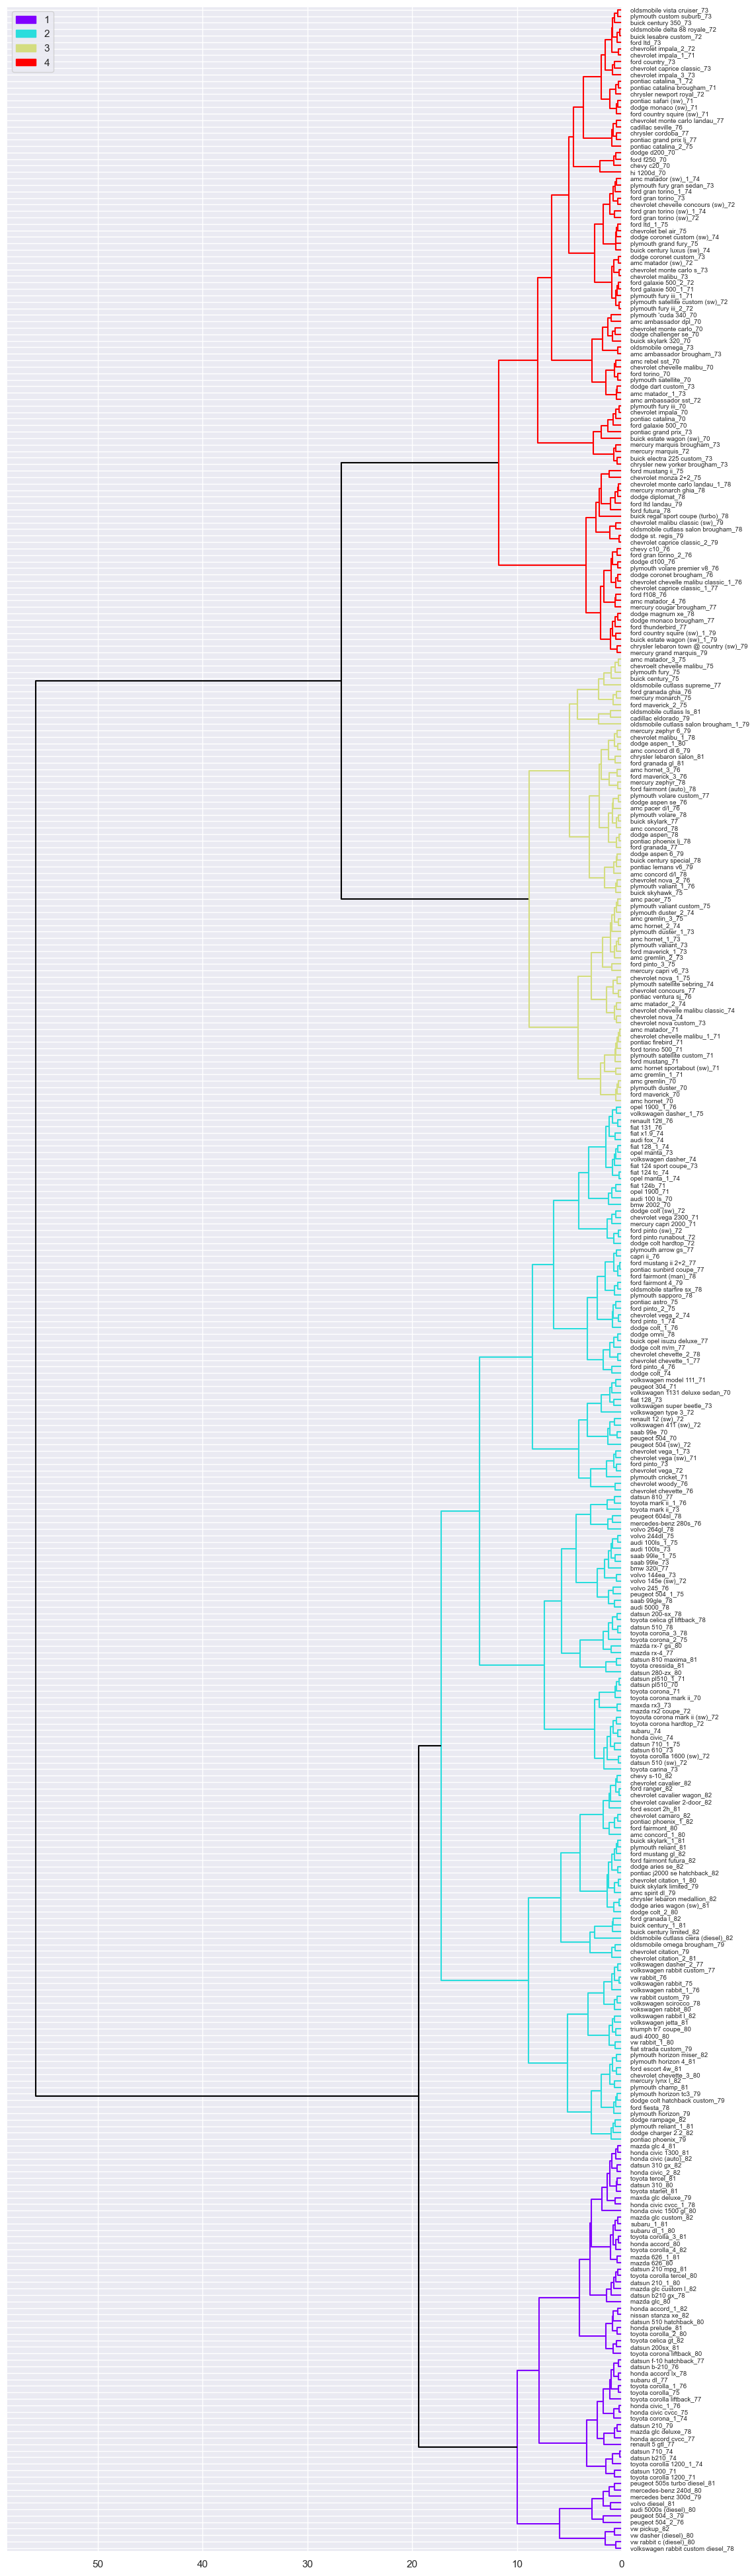

In [24]:
# Perform clustering based on height
clusters = fcluster(
    Z=linkage_matrix,
    t=18, 
    criterion='distance',
)

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=car_df,
    clusters=clusters,
    leaf_font_size=7
)

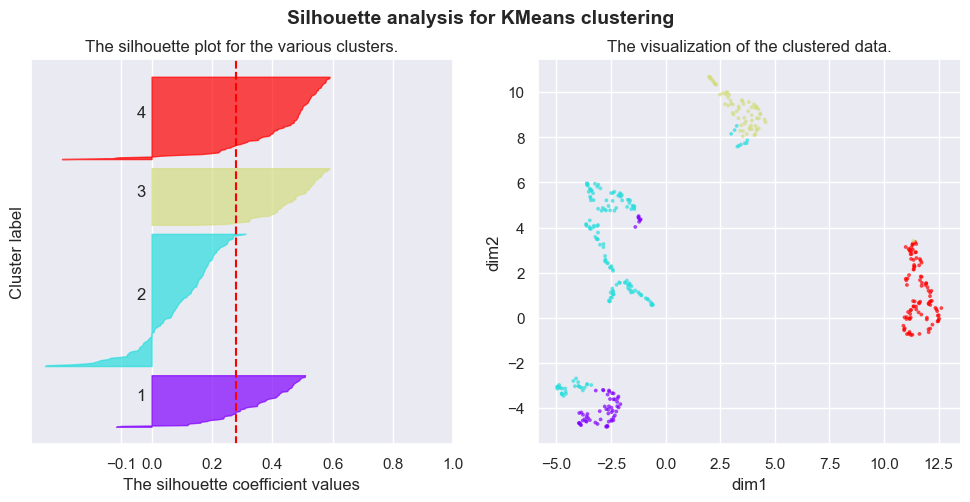

In [25]:
_ = plot_silouethes_agglomer(
    data_df=car_df,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx
)

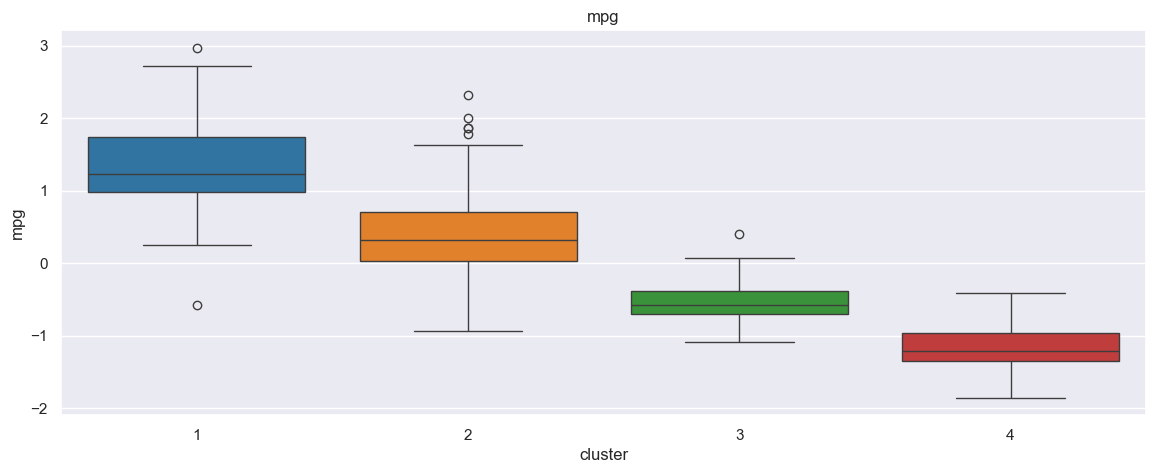

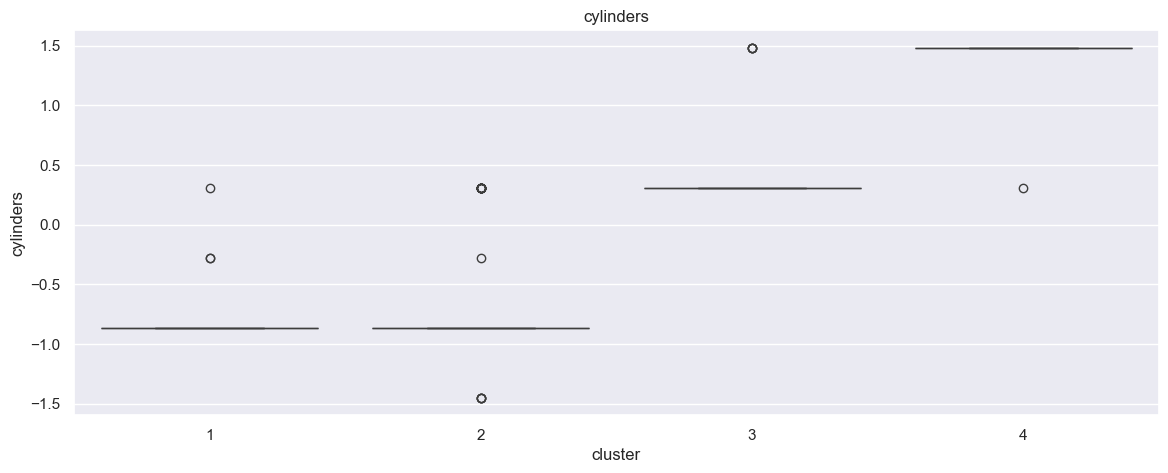

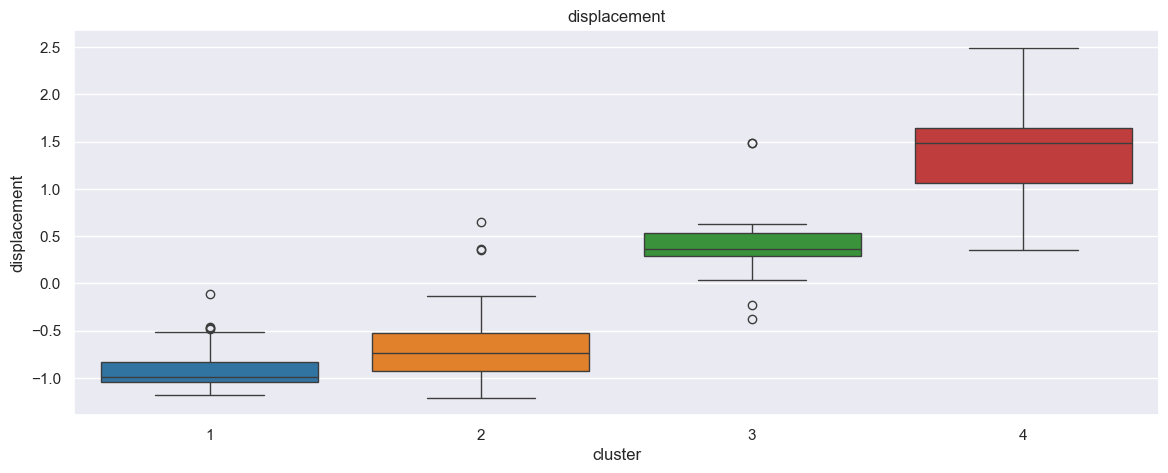

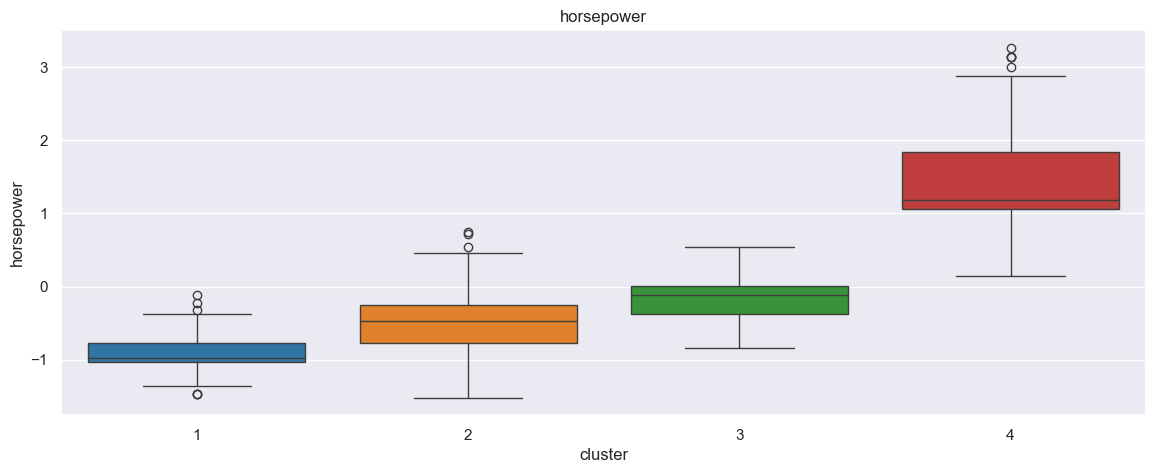

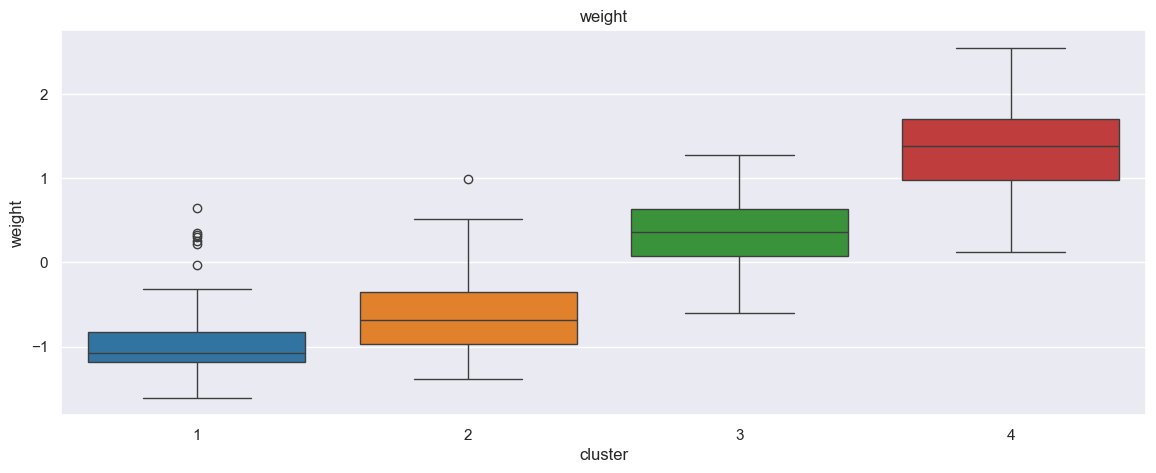

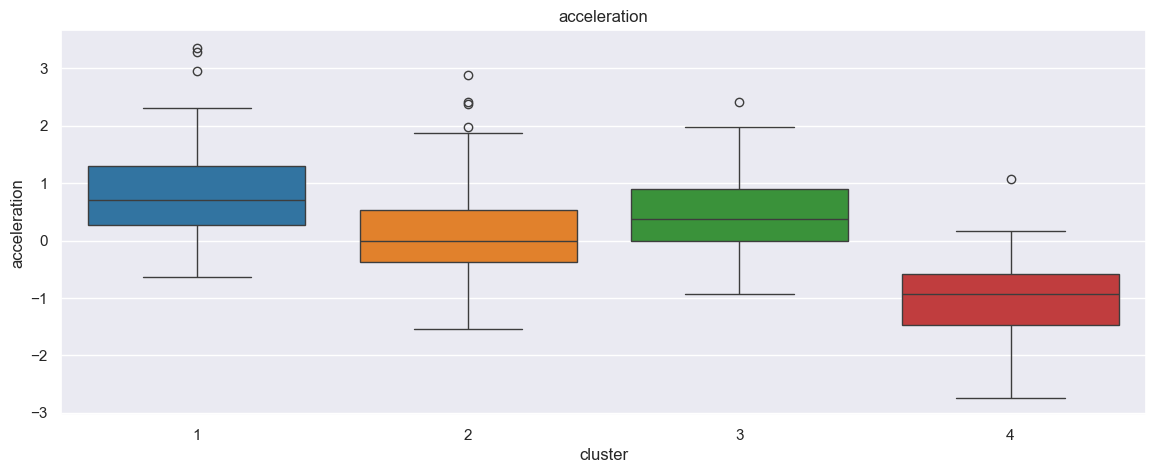

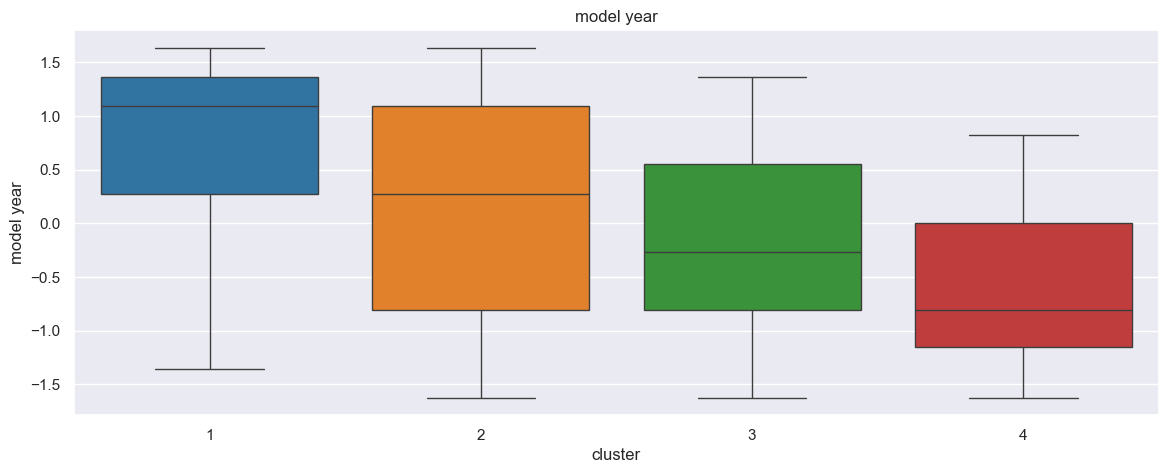

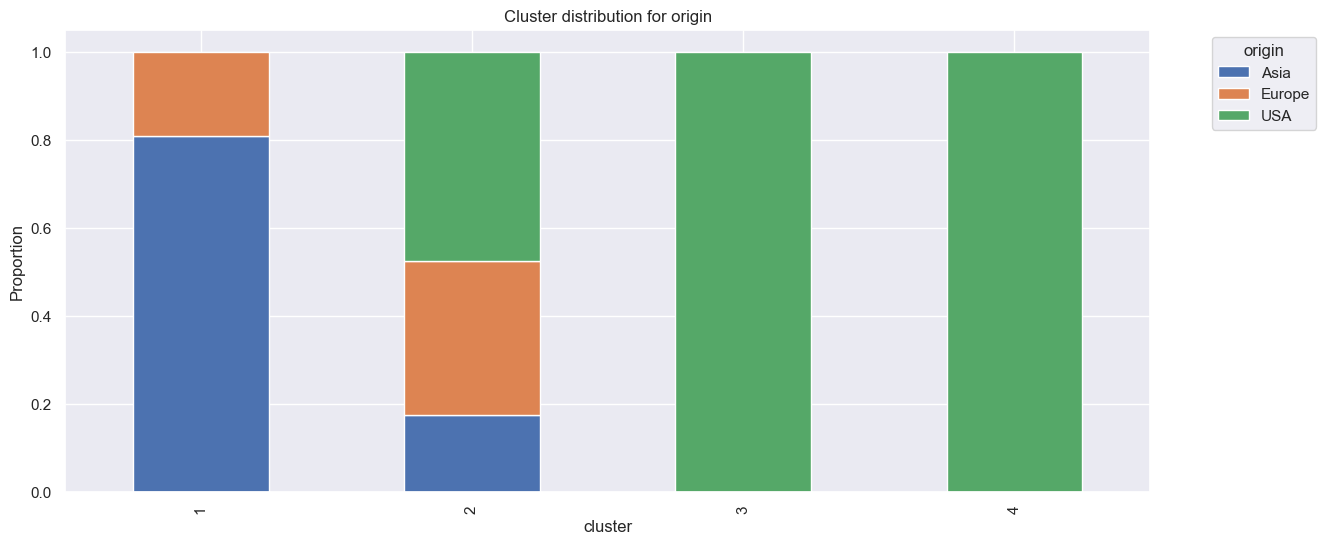

In [29]:
car_df_copy['cluster'] = clusters
numeric_col_names = car_df_copy.select_dtypes(include=[np.number]).columns.tolist()

# Plot features
for feature in car_df_copy.columns:
    
    if feature != 'cluster':
    
        if feature in numeric_col_names:
            
            plt.figure(figsize=(14,5))
            sns.boxplot(car_df_copy, x='cluster', y=feature, palette='tab10')
            plt.title(feature)
            
        else:
            
            proportions = car_df_copy.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()
            
            
                    
            # Create stacked bar plot
            ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6))
            plt.title(f'Cluster distribution for {feature}')
            plt.ylabel('Proportion')

            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()

### Clustering using inconsistency method

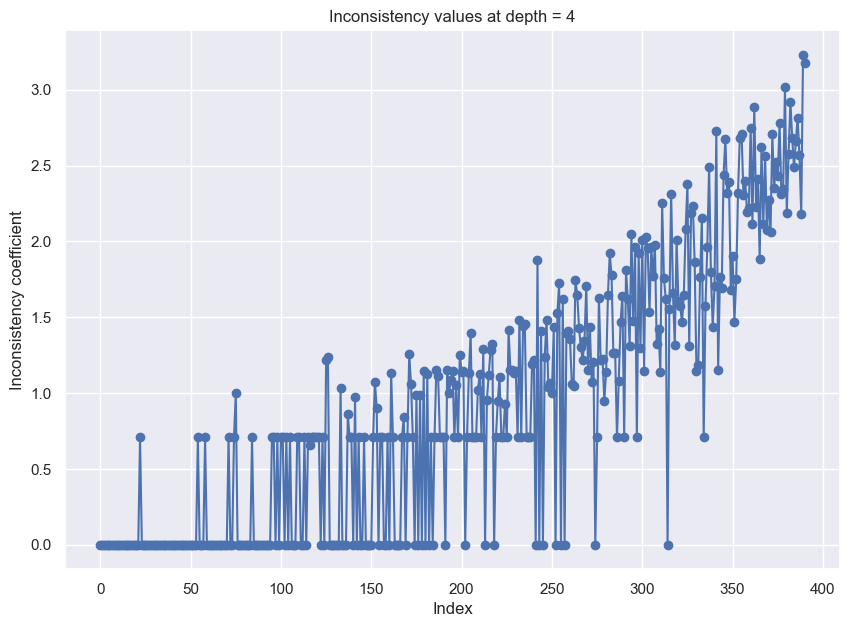

In [30]:
# Calculate inconsistence matrix
depth=4
incosistent_mtx = inconsistent(linkage_matrix,depth)

# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))
plt.plot(incosistent_mtx[:,-1])
plt.scatter(range(incosistent_mtx.shape[0]),incosistent_mtx[:,-1])
plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [31]:
# Perform clustering based on inconsistency
# and print clusters
clusters = fcluster(Z=linkage_matrix, t=2.7, criterion='inconsistent', R=incosistent_mtx)
clusters

array([18, 18, 18, 18, 18, 17, 17, 17, 17, 18, 18, 18, 18, 17, 10, 14, 14,
       14, 10, 11, 11, 13, 11, 13, 14, 21, 21, 21, 21, 10, 13, 10, 14, 14,
       14, 14, 14, 23, 23, 19, 19, 23, 23, 23, 14, 11, 14, 14, 13, 13, 11,
       13,  2,  2, 11, 11, 10, 13, 11, 11, 13, 23, 23, 19, 19, 18, 17, 23,
       23, 23, 10, 19, 20, 20, 19, 10, 11, 11, 11, 13, 10, 10, 13, 10, 23,
       18, 19, 20, 19, 17, 23, 23, 20, 17, 17, 18, 14, 14, 14, 14, 14, 11,
       23, 23, 23, 23, 14, 10, 11, 10, 10, 11, 14, 13, 19, 17, 11, 13, 10,
       10, 18, 10, 10, 18, 14, 14, 14,  2, 12,  2, 12, 14, 14, 14, 20, 20,
       20, 20, 20, 13, 13, 13,  2,  2, 12, 13, 13, 10, 10, 13, 14, 14, 15,
       15, 22, 20, 20, 20, 15, 15, 15, 15, 15, 16, 16,  2, 12, 14, 12, 10,
       13, 10, 14,  6, 14, 10, 10, 10, 10,  2, 13, 13, 12, 12, 13, 16, 16,
       16, 16, 15, 15, 15, 15, 11, 11,  6,  2, 15, 15, 14, 15,  6,  2,  2,
       12, 10, 16,  1, 10, 10, 22, 16, 16, 16,  2, 12,  2, 12,  2, 16, 15,
       16, 16, 14, 15, 15

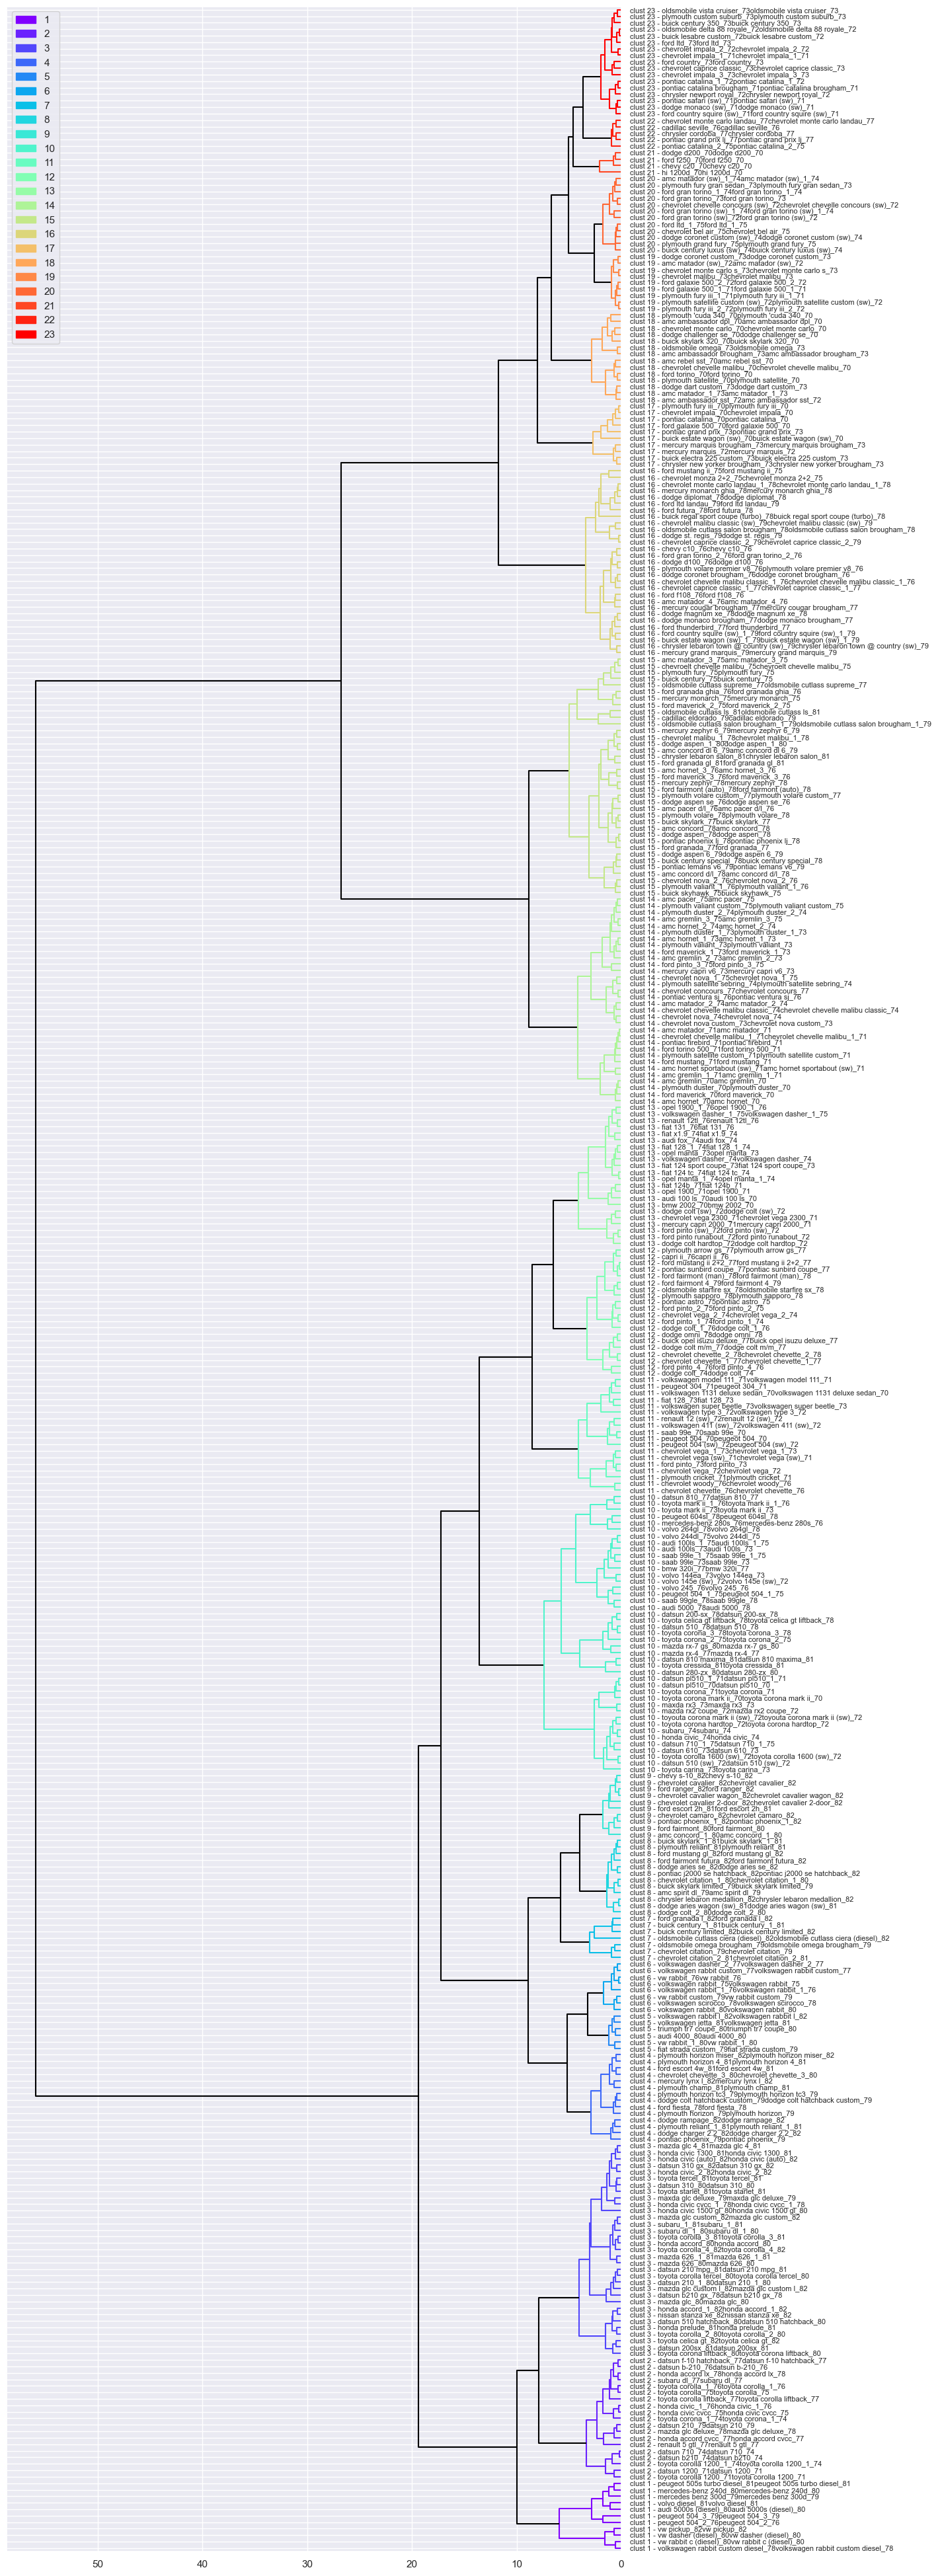

In [32]:
label_list = ['clust {} - {}'.format(clust, name) + name for name, clust in zip(car_df.index, clusters)]

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=car_df,
    clusters=clusters,
    leaf_font_size=8,
    labels=label_list
)

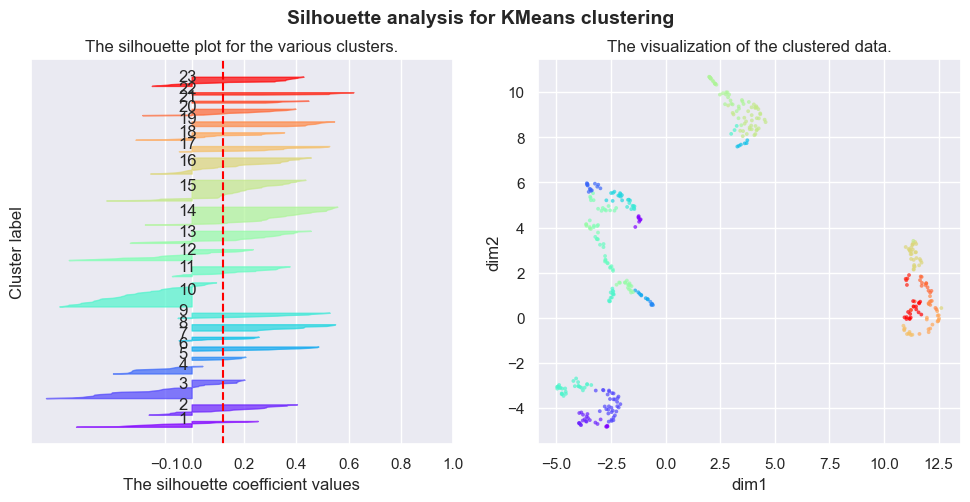

In [33]:
_ = plot_silouethes_agglomer(
    data_df=car_df,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx
)

### Cluster characterization

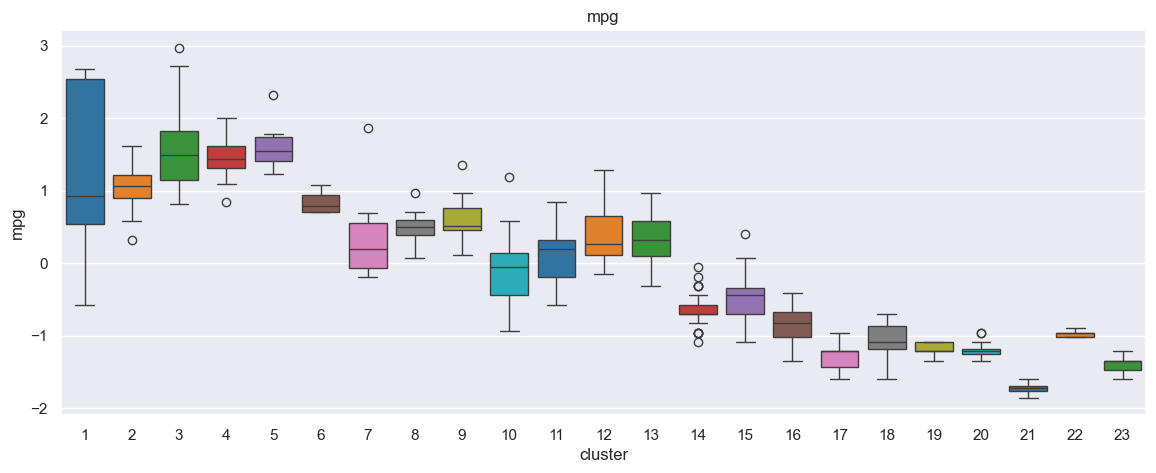

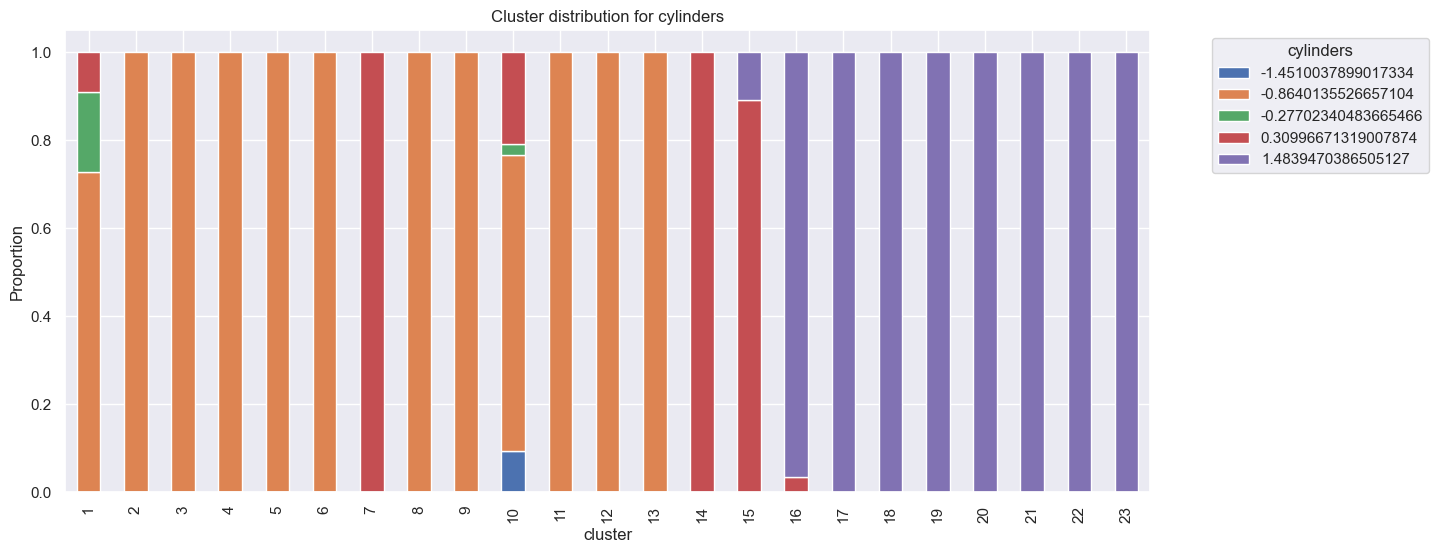

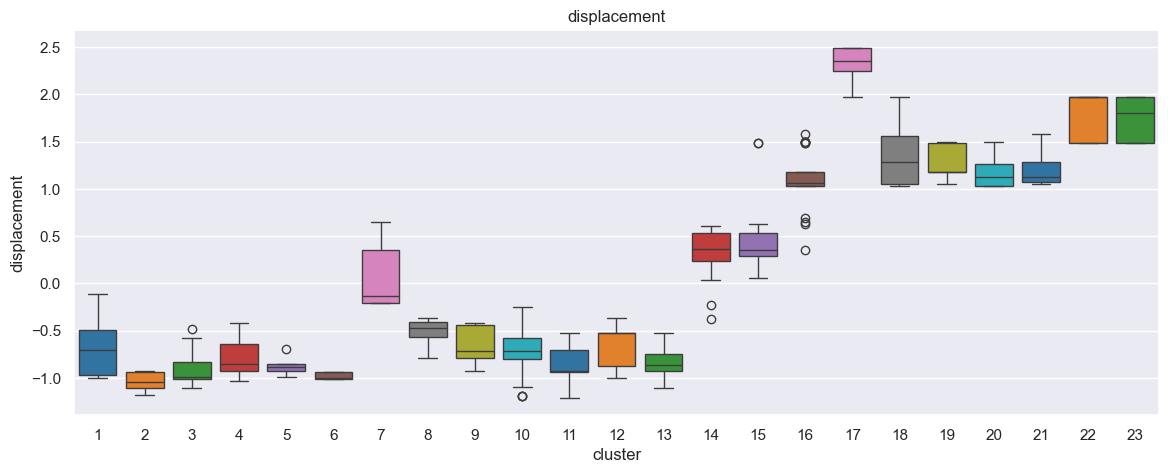

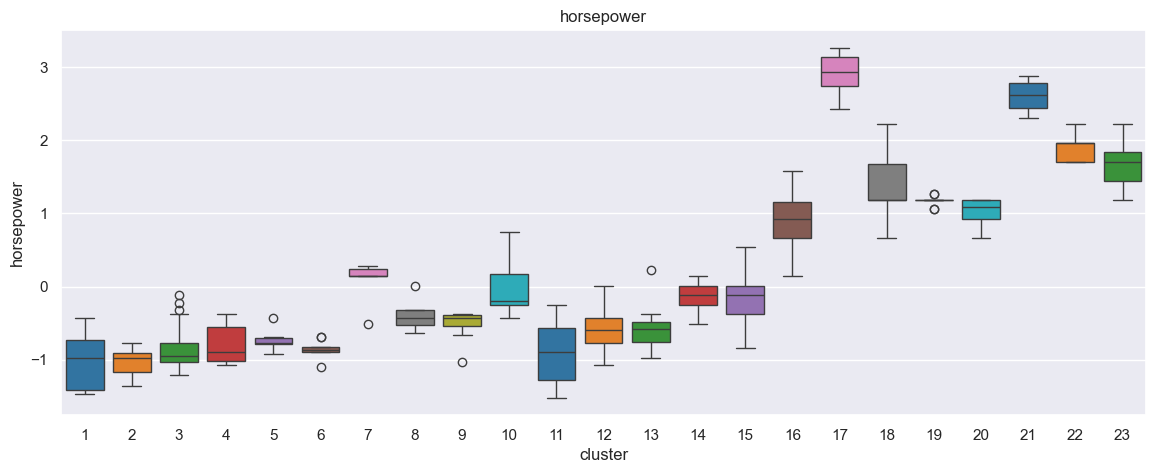

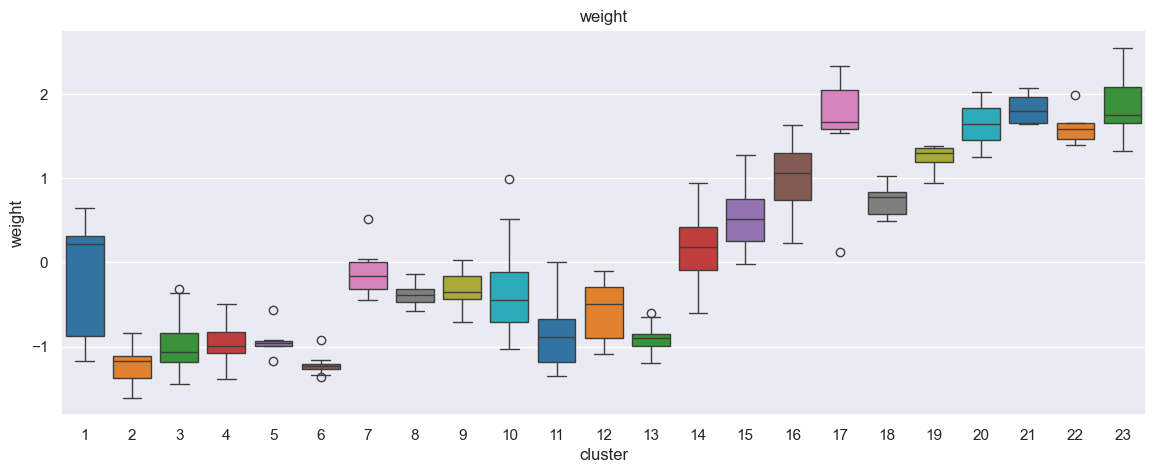

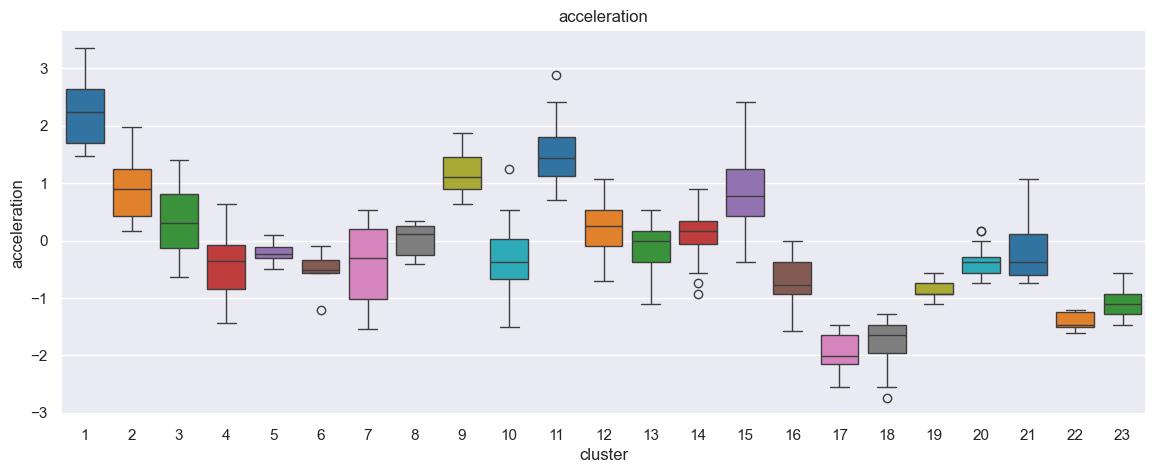

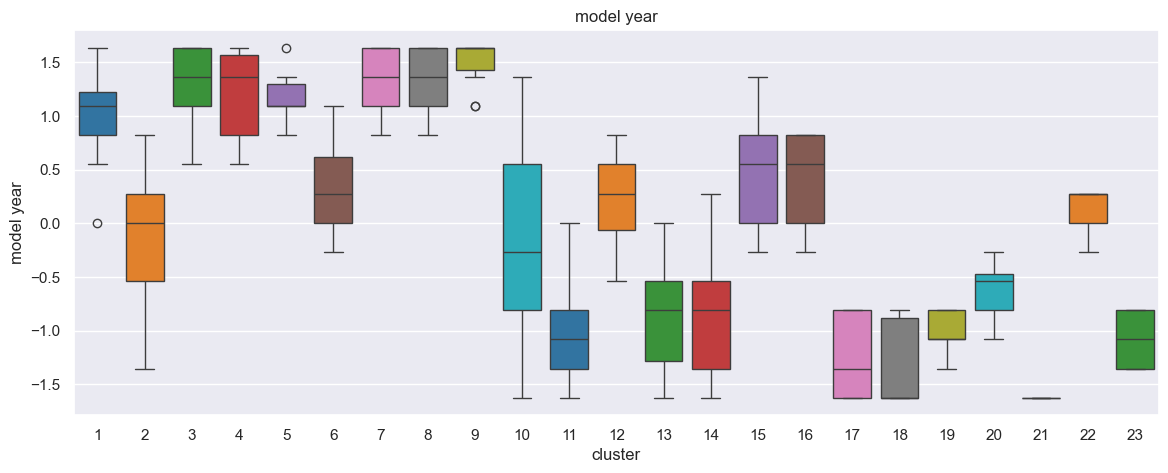

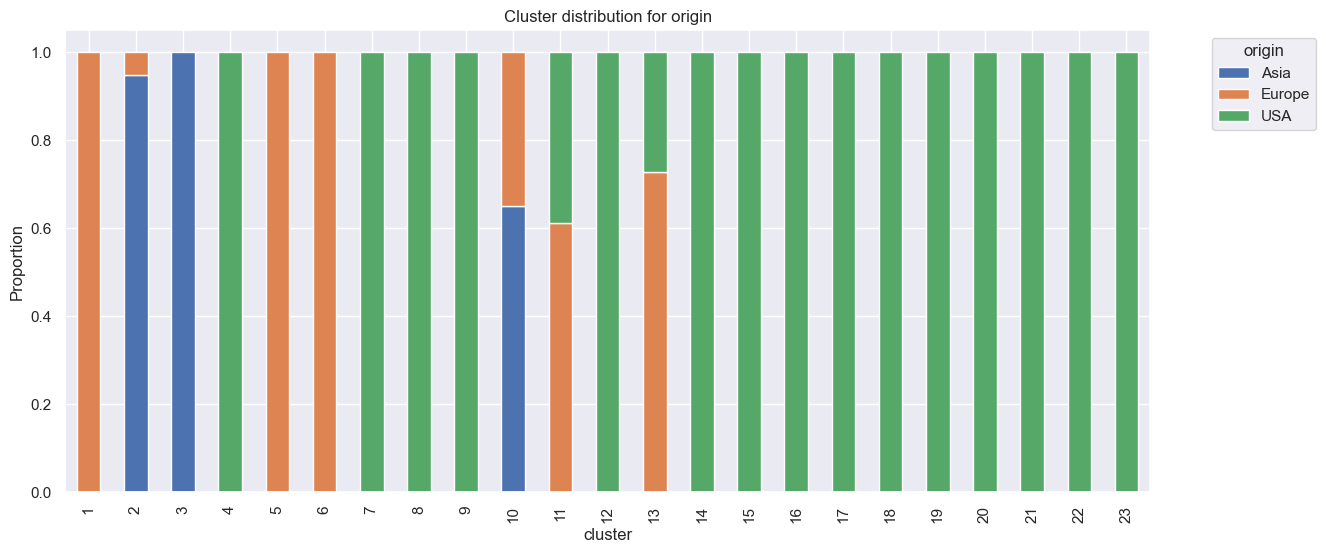

In [35]:
car_df_copy['cluster'] = clusters
car_df_copy['cylinders'] = car_df_copy['cylinders'].astype(object)
numeric_col_names = car_df_copy.select_dtypes(include=[np.number]).columns.tolist()

# Plot features
for feature in car_df_copy.columns:
    
    if feature != 'cluster':
    
        if feature in numeric_col_names:
            
            plt.figure(figsize=(14,5))
            sns.boxplot(car_df_copy, x='cluster', y=feature, palette='tab10')
            plt.title(feature)
            
        else:
            
            proportions = car_df_copy.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()
            
            
                    
            # Create stacked bar plot
            ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6))
            plt.title(f'Cluster distribution for {feature}')
            plt.ylabel('Proportion')

            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()

In [36]:
car_df_copy[car_df_copy['cluster']==23]

mpg cylinders  displacement  horsepower  \
car name                                                                      
chevrolet impala_1_71         -1.211785  1.483947      1.488732    1.574594   
pontiac catalina brougham_71  -1.211785  1.483947      1.967153    1.834726   
dodge monaco (sw)_71          -1.468358  1.483947      1.804490    1.964792   
ford country squire (sw)_71   -1.340071  1.483947      1.967153    1.704660   
pontiac safari (sw)_71        -1.340071  1.483947      1.967153    1.834726   
chevrolet impala_2_72         -1.340071  1.483947      1.488732    1.574594   
pontiac catalina_1_72         -1.211785  1.483947      1.967153    1.834726   
buick lesabre custom_72       -1.340071  1.483947      1.488732    1.314463   
oldsmobile delta 88 royale_72 -1.468358  1.483947      1.488732    1.444529   
chrysler newport royal_72     -1.340071  1.483947      1.967153    2.224924   
buick century 350_73          -1.340071  1.483947      1.488732    1.834726   
chevrolet caprice classic_73  -1.340071  1.483947      1.967153    1.184397   
ford ltd_73                   -1.340071  1.483947      1.498300    1.392502   
chevrolet impala_3_73         -1.596645  1.483947      1.967153    1.184397   
ford country_73               -1.468358  1.483947      1.967153    1.626621   
plymouth custom suburb_73     -1.340071  1.483947      1.584416    1.704660   
oldsmobile vista cruiser_73   -1.468358  1.483947      1.488732    1.964792   

                                 weight  acceleration  model year origin  \
car name                                                                   
chevrolet impala_1_71          1.451596     -1.285258   -1.353505    USA   
pontiac catalina brougham_71   1.752191     -1.466724   -1.353505    USA   
dodge monaco (sw)_71           2.330983     -1.466724   -1.353505    USA   
ford country squire (sw)_71    2.084613     -1.285258   -1.353505    USA   
pontiac safari (sw)_71         2.549061     -1.285258   -1.353505    USA   
chevrolet impala_2_72          1.528218     -1.285258   -1.081694    USA   
pontiac catalina_1_72          1.659065     -1.285258   -1.081694    USA   
buick lesabre custom_72        1.796985     -0.740861   -1.081694    USA   
oldsmobile delta 88 royale_72  1.742760     -0.740861   -1.081694    USA   
chrysler newport royal_72      1.702681     -1.103792   -1.081694    USA   
buick century 350_73           1.323107     -0.922327   -0.809884    USA   
chevrolet caprice classic_73   1.752191     -1.285258   -0.809884    USA   
ford ltd_73                    1.633132     -0.922327   -0.809884    USA   
chevrolet impala_3_73          2.380493     -0.559396   -0.809884    USA   
ford country_73                2.273221     -1.103792   -0.809884    USA   
plymouth custom suburb_73      1.976163     -0.922327   -0.809884    USA   
oldsmobile vista cruiser_73    1.793449     -1.103792   -0.809884    USA   

                               cluster  
car name                                
chevrolet impala_1_71               23  
pontiac catalina brougham_71        23  
dodge monaco (sw)_71                23  
ford country squire (sw)_71         23  
pontiac safari (sw)_71              23  
chevrolet impala_2_72               23  
pontiac catalina_1_72               23  
buick lesabre custom_72             23  
oldsmobile delta 88 royale_72       23  
chrysler newport royal_72           23  
buick century 350_73                23  
chevrolet caprice classic_73        23  
ford ltd_73                         23  
chevrolet impala_3_73               23  
ford country_73                     23  
plymouth custom suburb_73           23  
oldsmobile vista cruiser_73         23

In [37]:
car_df_copy[car_df_copy['cluster']==2]

mpg cylinders  displacement  horsepower  \
car name                                                                   
toyota corolla 1200_71      0.969087 -0.864014     -1.180858   -1.026725   
datsun 1200_71              1.482234 -0.864014     -1.171290   -0.922672   
datsun b210_74              0.969087 -0.864014     -1.104311   -0.974698   
toyota corolla 1200_1_74    1.097374 -0.864014     -1.180858   -1.026725   
toyota corona_1_74          0.969087 -0.864014     -1.133016   -1.364896   
datsun 710_74               1.097374 -0.864014     -1.066037   -1.130777   
toyota corolla_75           0.712514 -0.864014     -0.932079   -0.766593   
honda civic cvcc_75         1.225661 -0.864014     -0.989489   -1.338883   
honda civic_1_76            1.225661 -0.864014     -0.989489   -1.338883   
datsun b-210_76             1.097374 -0.864014     -1.046900   -0.896659   
toyota corolla_1_76         0.584228 -0.864014     -0.932079   -0.766593   
honda accord cvcc_77        1.033231 -0.864014     -0.922511   -0.948685   
renault 5 gtl_77            1.610521 -0.864014     -1.104311   -1.208817   
datsun f-10 hatchback_77    1.289804 -0.864014     -1.046900   -0.896659   
toyota corolla liftback_77  0.327654 -0.864014     -0.932079   -0.766593   
subaru dl_77                0.840801 -0.864014     -0.932079   -0.974698   
mazda glc deluxe_78         1.200003 -0.864014     -1.113879   -1.364896   
honda accord lx_78          0.776658 -0.864014     -0.922511   -0.948685   
datsun 210_79               1.071717 -0.864014     -1.046900   -1.026725   

                              weight  acceleration  model year  origin  \
car name                                                                 
toyota corolla 1200_71     -1.419967      1.255261   -1.353505    Asia   
datsun 1200_71             -1.608575      0.892329   -1.353505    Asia   
datsun b210_74             -1.211319      1.255261   -0.538074    Asia   
toyota corolla 1200_1_74   -1.345703      1.981123   -0.538074    Asia   
toyota corona_1_74         -1.566139      0.347933   -0.538074    Asia   
datsun 710_74              -1.148842      1.255261   -0.538074    Asia   
toyota corolla_75          -0.950804      0.166467   -0.266263    Asia   
honda civic cvcc_75        -1.394033      0.710864   -0.266263    Asia   
honda civic_1_76           -1.394033      0.674571    0.005547    Asia   
datsun b-210_76            -1.164167      0.529398    0.005547    Asia   
toyota corolla_1_76        -0.969664      0.311639    0.005547    Asia   
honda accord cvcc_77       -1.099333      1.073795    0.277358    Asia   
renault 5 gtl_77           -1.358669      1.110088    0.277358  Europe   
datsun f-10 hatchback_77   -1.217213      0.456812    0.277358    Asia   
toyota corolla liftback_77 -0.839996      0.964916    0.277358    Asia   
subaru dl_77               -1.170061      0.311639    0.277358    Asia   
mazda glc deluxe_78        -1.170061      1.400433    0.549168    Asia   
honda accord lx_78         -0.993240      0.384226    0.549168    Asia   
datsun 210_79              -1.128803      1.327847    0.820978    Asia   

                            cluster  
car name                             
toyota corolla 1200_71            2  
datsun 1200_71                    2  
datsun b210_74                    2  
toyota corolla 1200_1_74          2  
toyota corona_1_74                2  
datsun 710_74                     2  
toyota corolla_75                 2  
honda civic cvcc_75               2  
honda civic_1_76                  2  
datsun b-210_76                   2  
toyota corolla_1_76               2  
honda accord cvcc_77              2  
renault 5 gtl_77                  2  
datsun f-10 hatchback_77          2  
toyota corolla liftback_77        2  
subaru dl_77                      2  
mazda glc deluxe_78               2  
honda accord lx_78                2  
datsun 210_79                     2